In [25]:
import numpy as np
from tqdm import tqdm
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

from model import AttentionModel
from dcascore import *
from utils import read_fasta_alignment, remove_duplicate_sequences

# back to original path (in PLM)
sys.path.pop(0)
from gillespie import SequenceGill
from plm_seq_utils import nums_to_letters, modify_seq, letters_to_nums, set_seed, read_tensor_from_txt
from plm_PCA_func import *
from plm_hamming_dist import vectorized_hamming_distance, energy_corr_array
#-----------------------------------Functions--------------------------------------------

def gennerate_gill(J,N_seqs=40000, init_sequence=None, beta=1):
    gen_sequences = []
    time_seq=[]
    seq = SequenceGill(J, init_sequence, beta=1)
    for _ in tqdm(range(N_seqs)):
        seq.draw_aa()
        gen_sequences.append(seq.sequence.copy())
        time_seq.append(seq.time)
    gen_sequences = np.array(gen_sequences)
    time_seq = np.array(time_seq)
    return gen_sequences, time_seq

def generate_gill_n_save(save_dir, save_name, J, N_seqs=10000, init_sequence=None):
    """
    Generates a set of sequences using Gillespie and saves them both as a numpy file and a text file containing the corresponding letter sequences.
    Saves:
    - A `.npy` file containing the generated sequences in numerical format.
    - A `.txt` file containing the generated sequences in letter format.
    """
    gen_sequences, time_seq = gennerate_gill(J, N_seqs, init_sequence)
    gen_sequences_letters = [nums_to_letters(sequence) for sequence in gen_sequences]
    
    print(f"Generated sequences (letters): {gen_sequences_letters[:5]}")  # Show first 5 sequences
    
    gen_sequences = np.array(gen_sequences)
        
    # Check if the directory exists, create it if not
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save the sequences in numerical format as a .npy file
    np.save(f"{save_dir}/{save_name}.npy", gen_sequences)
    np.save(f"{save_dir}/{save_name}_time_seq.npy", time_seq)
    # Save the sequences in letter format as a .txt file (each sequence on a new line)
    with open(f"{save_dir}/{save_name}.txt", "w") as f:
        for sequence in gen_sequences_letters:
            f.write(f"{sequence}\n")

    print(f"Generated sequences saved to {save_dir}")


#-----------------------------------Main--------------------------------------------

##############################################################
"""
    Load Q, K, V matrices from jdoms (after training)
"""
set_seed()
H = 64
d= 10
N = 174
n_epochs = 500
loss_type = 'without_J'
family = 'jdoms' #'jdoms_bacteria_train2'
#cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main/CODE/AttentionDCA_python/src'
cwd=r'C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\git_test\PLM-gen-DCA\Attention-DCA-main\CODE\AttentionDCA_python\src'

# Q_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/Q_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
# K_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/K_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
# V_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/V_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
Q_1 = read_tensor_from_txt( cwd +r'\results\{H}_{d}_{family}_{losstype}_{n_epochs}_youss\Q_tensor.txt'.format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
K_1 = read_tensor_from_txt( cwd +r'\results\{H}_{d}_{family}_{losstype}_{n_epochs}_youss\K_tensor.txt'.format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
V_1 = read_tensor_from_txt( cwd +r'\results\{H}_{d}_{family}_{losstype}_{n_epochs}_youss\V_tensor.txt'.format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
H,d,N=Q_1.shape
q=V_1.shape[1]

##############################################################
"""
    Initialize the model and compute couplings J from Q, K, V
""" 
model=AttentionModel(H,d,N,q,Q=Q_1,V=V_1,K=K_1)
torch.sum(model.Q-Q_1)
device = Q_1.device
L = Q_1.shape[-1]
W=attention_heads_from_model(model,Q_1,K_1,V_1)
print(W.shape)

i_indices = torch.arange(L, device=device).unsqueeze(1)
j_indices = torch.arange(L, device=device).unsqueeze(0)
mask = (i_indices != j_indices).float().unsqueeze(0)  # shape (1, L, L)
W = W * mask
    
# Compute Jtens
Jtens = torch.einsum('hri,hab->abri', W, V_1)  # Shape: (q, q, L, L)
q = Jtens.shape[0]
N = Jtens.shape[2]
print(q)
print(N)

##############################################################
"""
    Generate sequences with PLM random initialization
"""
save_dir = "gill_generated_sequences"
N_seqs = 10000
save_name = "gill_generated_sequences_randinit_10000"
#generate_gill_n_save(save_dir, save_name, Jtens, N_seqs=10000, init_sequence=None)

##############################################################
"""
    Generate sequences with PLM initialization from a sequence
"""
init_sequence = 'DYYQVLGVPKDADAKSIKKAFRKLARKYHPDVNPGDKEAERKFKEANEANEVLSDPEKRKKYD'
init_sequence_num = letters_to_nums(init_sequence)
ratio = 0.3
init_sequence_num = modify_seq(init_sequence_num, ratio)
N_seqs=30000
save_name = f"gill_gen_seqs_w_init_seq_Ns{N_seqs}_r{ratio}"
#generate_gill_n_save(save_dir, save_name, Jtens, N_seqs, init_sequence=init_sequence_num)

torch.Size([64, 63, 63])
21
63


Total sequences read: 14502
Sequences after filtering: 14502
(63, 14502)
Removing duplicate sequences...
Done: 14502 -> 14502 sequences after removing duplicates.


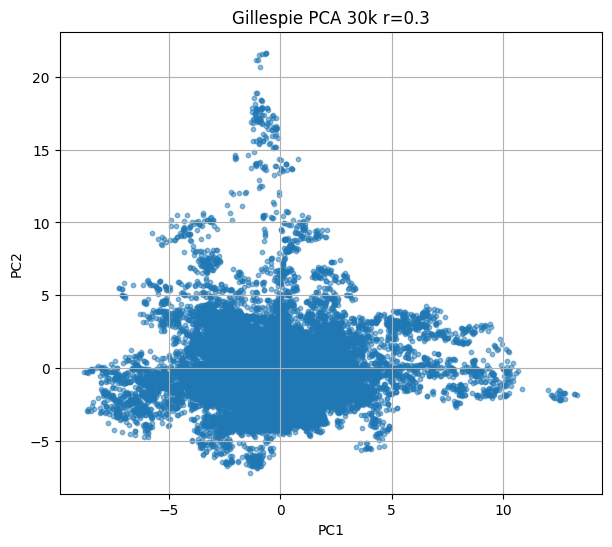

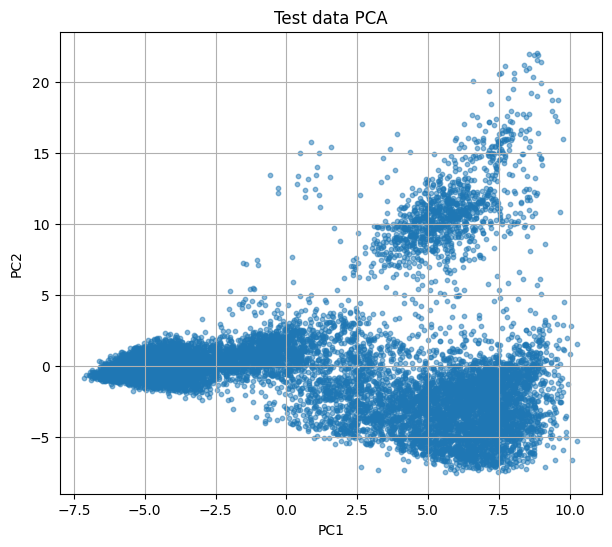

In [26]:
gill_gen_seq=np.load(save_dir+"\\"+save_name+".npy")
gill_gen_seq.shape
file_test_data=r"C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\git_test\PLM-gen-DCA\Attention-DCA-main\CODE\DataAttentionDCA\jdoms\jdoms_bacteria_train2.fasta"
seq_data_test=read_fasta_alignment(file_test_data,0.8)

print(seq_data_test.shape)
seq_data_test_filtered,_=remove_duplicate_sequences(seq_data_test)
seq_data_test_filtered=seq_data_test_filtered.T
plot_pca_of_sequences(gill_gen_seq[5000:],title='Gillespie PCA 30k r=0.3')
plot_pca_of_sequences(seq_data_test_filtered,title='Test data PCA')

(30000,)


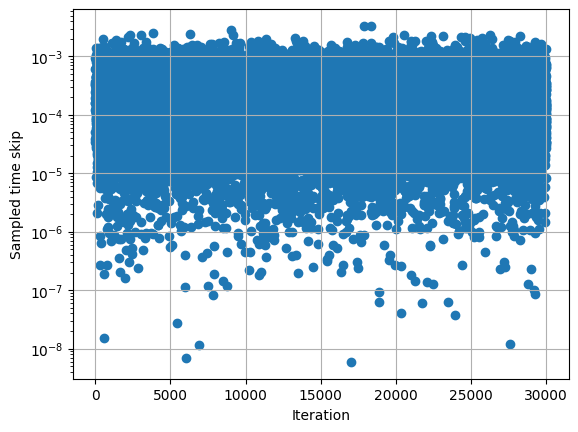

In [27]:
gill_time_skip=np.load(save_dir+"\\"+save_name+"_time_seq.npy")
print(gill_time_skip.shape)
plt.scatter(np.arange(len(gill_time_skip)),gill_time_skip)
plt.xlabel('Iteration')
plt.ylabel('Sampled time skip')
plt.yscale('log')
plt.grid(True)
plt.show()

The average hamming distance between gillespie and test data is :  40.36546683216108
The standard variation is :  6.500464247180741


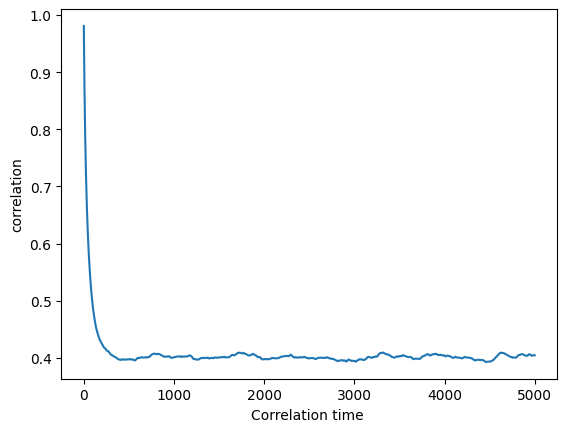

In [29]:
hamming_dist=vectorized_hamming_distance(gill_gen_seq,seq_data_test_filtered)
print("The average hamming distance between gillespie and test data is : ",np.mean(hamming_dist))
print("The standard variation is : ", np.std(hamming_dist))
correlation_func=energy_corr_array(gill_gen_seq,5000)
plt.plot(correlation_func)
plt.xlabel('Correlation time ')
plt.ylabel('correlation')
plt.show()